<a href="https://colab.research.google.com/github/fc63/493homework1/blob/main/Copy_of_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv

--2024-10-20 10:40:25--  https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5698602 (5.4M) [text/csv]
Saving to: ‘tmdb_5000_movies.csv’

tmdb_5000_movies.cs 100%[===================>]   5.43M  --.-KB/s    in 0.1s    

2024-10-20 10:40:26 (52.2 MB/s) - ‘tmdb_5000_movies.csv’ saved [5698602/5698602]



In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import json
import nltk

nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)

True

In [ ]:
df = pd.read_csv(
    "tmdb_5000_movies.csv",
    usecols=["title", "overview", "genres", "keywords", "tagline"],
)
df = df.dropna()
df[['title', 'overview', 'tagline', 'genres', 'keywords']]

,title,overview,tagline,genres,keywords
0,Avatar,"In the 22nd century, a paraplegic Marine is di...",Enter the World of Pandora.,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":..."
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","At the end of the world, the adventure begins.","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na..."
2,Spectre,A cryptic message from Bond’s past sends him o...,A Plan No One Escapes,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name..."
3,The Dark Knight Rises,Following the death of District Attorney Harve...,The Legend Ends,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,..."
4,John Carter,"John Carter is a war-weary, former military ca...","Lost in our world, found in another.","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":..."
...,...,...,...,...,...
4795,Bang,A young woman in L.A. is having a bad day: she...,Sometimes you've got to break the rules,"[{""id"": 18, ""name"": ""Drama""}]","[{""id"": 10726, ""name"": ""gang""}, {""id"": 33928, ..."
4796,Primer,Friends/fledgling entrepreneurs invent a devic...,What happens if it actually works?,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...","[{""id"": 1448, ""name"": ""distrust""}, {""id"": 2101..."
4798,El Mariachi,El Mariachi just wants to play his guitar and ...,"He didn't come looking for trouble, but troubl...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 5616, ""name"": ""united states\u2013mexi..."
4799,Newlyweds,A newlywed couple's honeymoon is upended by th...,A newlywed couple's honeymoon is upended by th...,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",[]


In [ ]:
def genres_and_keywords_to_string(row):
    genres = " ".join(
        [genre["name"].replace(" ", "") for genre in json.loads(row["genres"])]
    )
    keywords = " ".join(
        [keyword["name"].replace(" ", "") for keyword in json.loads(row["keywords"])]
    )
    tagline = row["tagline"] if pd.notnull(row["tagline"]) else ""
    return f"{genres} {keywords} {tagline}"


df["genres_keywords_tagline"] = df.apply(genres_and_keywords_to_string, axis=1)
df[["title", "overview", "genres_keywords_tagline"]]

,title,overview,genres_keywords_tagline
0,Avatar,"In the 22nd century, a paraplegic Marine is di...",Action Adventure Fantasy ScienceFiction cultur...
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",Adventure Fantasy Action ocean drugabuse exoti...
2,Spectre,A cryptic message from Bond’s past sends him o...,Action Adventure Crime spy basedonnovel secret...
3,The Dark Knight Rises,Following the death of District Attorney Harve...,Action Crime Drama Thriller dccomics crimefigh...
4,John Carter,"John Carter is a war-weary, former military ca...",Action Adventure ScienceFiction basedonnovel m...
...,...,...,...
4795,Bang,A young woman in L.A. is having a bad day: she...,Drama gang audition policefake homeless actres...
4796,Primer,Friends/fledgling entrepreneurs invent a devic...,ScienceFiction Drama Thriller distrust garage ...
4798,El Mariachi,El Mariachi just wants to play his guitar and ...,Action Crime Thriller unitedstates–mexicobarri...
4799,Newlyweds,A newlywed couple's honeymoon is upended by th...,Comedy Romance A newlywed couple's honeymoon ...


In [ ]:
df["combined_text"] = df["overview"] + " " + df["genres_keywords_tagline"]
df[["title", "combined_text"]]

,title,combined_text
0,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
2,Spectre,A cryptic message from Bond’s past sends him o...
3,The Dark Knight Rises,Following the death of District Attorney Harve...
4,John Carter,"John Carter is a war-weary, former military ca..."
...,...,...
4795,Bang,A young woman in L.A. is having a bad day: she...
4796,Primer,Friends/fledgling entrepreneurs invent a devic...
4798,El Mariachi,El Mariachi just wants to play his guitar and ...
4799,Newlyweds,A newlywed couple's honeymoon is upended by th...


In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    clean_text = text.lower()
    words = [
        lemmatizer.lemmatize(word)
        for word in word_tokenize(clean_text)
        if word.isalnum() and word not in stop_words
    ]
    return " ".join(words)


df["clean_combined_text"] = df["combined_text"].apply(clean_text)
df[['title', 'combined_text', 'clean_combined_text']]

,title,combined_text,clean_combined_text
0,Avatar,"In the 22nd century, a paraplegic Marine is di...",22nd century paraplegic marine dispatched moon...
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",captain barbossa long believed dead come back ...
2,Spectre,A cryptic message from Bond’s past sends him o...,cryptic message bond past sends trail uncover ...
3,The Dark Knight Rises,Following the death of District Attorney Harve...,following death district attorney harvey dent ...
4,John Carter,"John Carter is a war-weary, former military ca...",john carter former military captain inexplicab...
...,...,...,...
4795,Bang,A young woman in L.A. is having a bad day: she...,young woman bad day evicted audition end produ...
4796,Primer,Friends/fledgling entrepreneurs invent a devic...,entrepreneur invent device garage reduces appa...
4798,El Mariachi,El Mariachi just wants to play his guitar and ...,el mariachi want play guitar carry family trad...
4799,Newlyweds,A newlywed couple's honeymoon is upended by th...,newlywed couple honeymoon upended arrival resp...


In [ ]:
pretrained_w2v = api.load("word2vec-google-news-300")
pretrained_glove = api.load("glove-wiki-gigaword-300")
pretrained_fasttext = api.load("fasttext-wiki-news-subwords-300")

"""
örnek olarak bir sorgunun vektörel değeri nasıl hesaplanır diye baktığımızda;
öncelikle pretrained_w2v[word] ile Word2Vec modelinden kelimenin 300 boyutlu vektörü çekiliyor
(bu vektörlerin değerleri ve uzunlukları eğitilen modele göre değişiklik gösteriyor)
(modellerin üçünde de vektör boyutu 300 vektörle sınırlı)
çekilen vektördeki sayılar; modelin eğitildiği veri kümesi üzerinde, kelimenin diğer kelimelerle olan ilişkisini yansıtan,
(makine için anlamlı olan) sayısal bir dil(daha uygun bir kelime bulamadım).
model, eğitim sürecinde eğitildiği datasete göre, kelimenin bağlamı, kelimeye yakın diğer kelimelerden vs. etkilenerek bu sayısal değeri belirliyor.
dolayısıyla aynı kelime için aynı modelden hep aynı vektörü alıyoruz.
yazdığım get_vector fonksiyonu ise her kelimenin vektörünü modelden alıyor ve bu vektörlerin ortalamasını alarak
verdiğimiz text'in genel vektörünü oluşturuyor.
şöyle ki; kelimeler tek tek vektör olarak modelden alınıp listeye ekleniyor,
ve daha sonra bu liste içerisindeki tüm kelime vektörlerinin ortalaması alınarak nihai vektör (mesela word2vec_vector) hesaplanıyor.
kelime vektörlerinin modelde birbirine olan uzaklığı, Word2Vec'in eğitildiği süreçte öğrenilen anlamsal ilişkilerle makine tarafından belirlenmiş.
yani, modelden alınan 300 vektörlük verideki her vektör aslında o kelimenin diğer kelimelere olan "anlamsal uzaklıklarını" içeren bilgisayarın anladığı dilde bir temsili dil.
bu vektörlerin içerdikleri sayıların, insanlar için anlam ifade etmesi ve anlamlandırılmaları zor gözüküyor.
"""


def get_vector(text, model):
    words = text.split()
    word_vecs = [model[word] for word in words if word in model]
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(300)


df["word2vec_vector"] = df["clean_combined_text"].apply(
    lambda text: get_vector(text, pretrained_w2v)
)
df["glove_vector"] = df["clean_combined_text"].apply(
    lambda text: get_vector(text, pretrained_glove)
)
df["fasttext_vector"] = df["clean_combined_text"].apply(
    lambda text: get_vector(text, pretrained_fasttext)
)

tfidf_vectorizer = TfidfVectorizer(max_features=2000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df["clean_combined_text"])
df["tfidf_vector"] = list(tfidf_matrix.toarray())
df[
    [
        "title",
        "clean_combined_text",
        "word2vec_vector",
        "glove_vector",
        "fasttext_vector",
        "tfidf_vector",
    ]
]

[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 376.1/376.1MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded


,title,clean_combined_text,word2vec_vector,glove_vector,fasttext_vector,tfidf_vector
0,Avatar,22nd century paraplegic marine dispatched moon...,"[0.06455814, 0.05200375, -0.011962891, 0.06401...","[-0.027988898, -0.022615276, -0.017876057, -0....","[-0.010888328, -0.02125517, 0.049644634, 0.021...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Pirates of the Caribbean: At World's End,captain barbossa long believed dead come back ...,"[0.070882164, 0.045965947, 0.01393821, 0.09197...","[-0.08289482, -0.09457336, 0.07866199, -0.0707...","[-0.012833232, -0.025485784, 0.019201852, 0.02...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Spectre,cryptic message bond past sends trail uncover ...,"[0.088998504, 0.020824548, 0.017934164, 0.0059...","[-0.1984442, -0.10905185, 0.042675946, -0.0855...","[0.022941604, 0.0060877395, 0.006602119, 0.015...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,The Dark Knight Rises,following death district attorney harvey dent ...,"[0.031004842, 0.059774272, -0.004252243, 0.035...","[-0.0061914586, -0.040345233, 0.12360908, -0.0...","[-9.5008045e-06, -0.020093668, 0.02257172, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,John Carter,john carter former military captain inexplicab...,"[0.07618974, 0.06453984, -0.023357112, 0.06665...","[0.031585146, 0.053976424, 0.033191, -0.179748...","[-0.0014101333, -0.008080206, 0.035394445, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
4795,Bang,young woman bad day evicted audition end produ...,"[0.0554619, 0.07521868, -0.027497768, 0.039587...","[-0.06569035, 0.031295747, -0.040654335, -0.07...","[-0.006788074, -0.012955292, 0.02176901, 0.029...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4796,Primer,entrepreneur invent device garage reduces appa...,"[0.07875061, 0.0044311523, -0.0026361465, 0.04...","[-0.073393665, 0.15139349, 0.017786045, -0.143...","[0.0013687611, 0.008328168, 0.0066336263, 0.00...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4798,El Mariachi,el mariachi want play guitar carry family trad...,"[0.06376827, 0.025567237, 0.04862424, 0.084806...","[-0.026085204, 0.095240064, -0.165051, -0.0739...","[0.014343827, -0.009477464, 0.00075535494, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4799,Newlyweds,newlywed couple honeymoon upended arrival resp...,"[0.00440979, -0.010494232, -0.18625546, 0.0469...","[-0.18655337, -0.062100563, -0.14488013, 0.157...","[0.0008659458, 0.0016903504, 0.02492081, 0.030...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
query_film = "The Matrix"

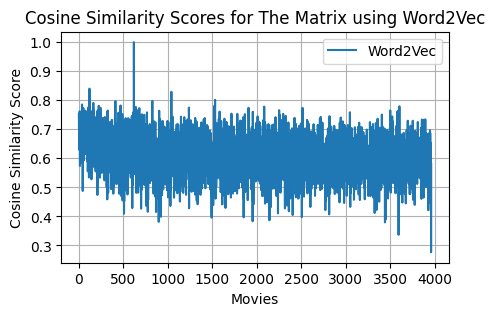

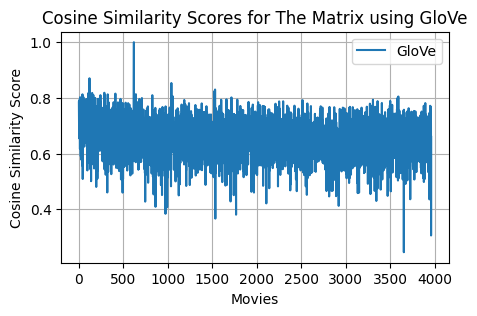

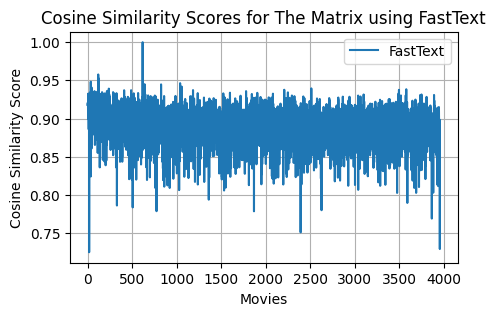

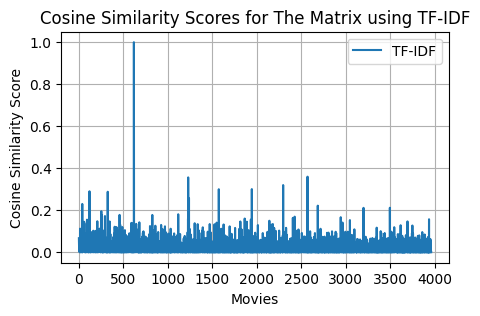

In [ ]:
def plot_similarity_scores(title, vector_column, model_name):
    indices = pd.Series(df.index, index=df["title"]).drop_duplicates()
    idx = indices.get(title)

    if idx is None:
        print(f"Movie titled '{title}' not found.")
        return

    query_vec = df.loc[idx, vector_column].reshape(1, -1)
    cosine_similarities = cosine_similarity(
        query_vec, np.vstack(df[vector_column].values)
    )
    scores = cosine_similarities.flatten()

    plt.figure(figsize=(5, 3))
    plt.plot(scores, label=model_name)
    plt.title(f"Cosine Similarity Scores for {title} using {model_name}")
    plt.xlabel("Movies")
    plt.ylabel("Cosine Similarity Score")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_similarity_scores(query_film, "word2vec_vector", "Word2Vec")
plot_similarity_scores(query_film, "glove_vector", "GloVe")
plot_similarity_scores(query_film, "fasttext_vector", "FastText")
plot_similarity_scores(query_film, "tfidf_vector", "TF-IDF")

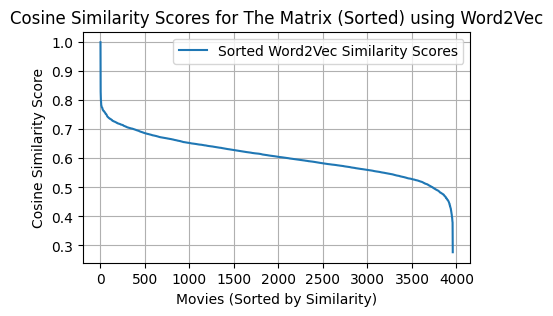

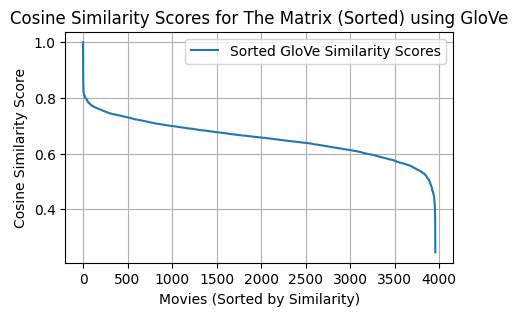

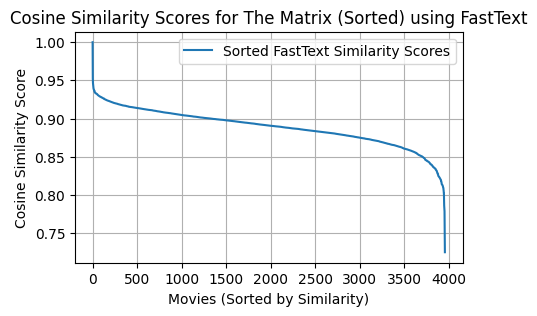

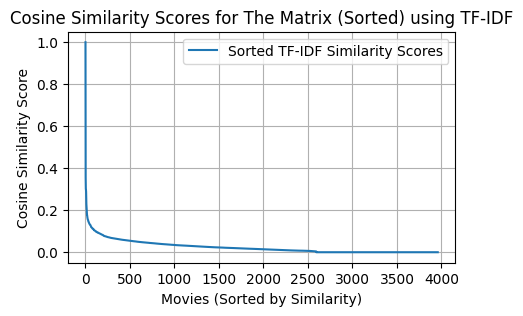

In [ ]:
def plot_sorted_similarity_scores(title, vector_column, model_name):
    indices = pd.Series(df.index, index=df["title"]).drop_duplicates()
    idx = indices.get(title)

    if idx is None:
        print(f"Movie titled '{title}' not found.")
        return

    query_vec = df.loc[idx, vector_column].reshape(1, -1)
    cosine_similarities = cosine_similarity(
        query_vec, np.vstack(df[vector_column].values)
    )
    scores = cosine_similarities.flatten()
    sorted_scores = scores[(-scores).argsort()]

    plt.figure(figsize=(5, 3))
    plt.plot(sorted_scores, label=f"Sorted {model_name} Similarity Scores")
    plt.title(f"Cosine Similarity Scores for {title} (Sorted) using {model_name}")
    plt.xlabel("Movies (Sorted by Similarity)")
    plt.ylabel("Cosine Similarity Score")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_sorted_similarity_scores(query_film, "word2vec_vector", "Word2Vec")
plot_sorted_similarity_scores(query_film, "glove_vector", "GloVe")
plot_sorted_similarity_scores(query_film, "fasttext_vector", "FastText")
plot_sorted_similarity_scores(query_film, "tfidf_vector", "TF-IDF")

In [ ]:
def compare_recommendations(title):
    print(f"For the movie: {title}")

    models = {
        "Word2Vec": "word2vec_vector",
        "GloVe": "glove_vector",
        "FastText": "fasttext_vector",
        "TF-IDF": "tfidf_vector",
    }

    for model_name, vector_column in models.items():
        recommended_movies, sim_scores = get_recommendations(title, vector_column)
        if isinstance(recommended_movies, str):
            print(recommended_movies)
            continue
        print(f"\nMovies recommended using {model_name}:")
        for i, (movie, score) in enumerate(zip(recommended_movies, sim_scores), 1):
            print(f"{i}. {movie} - Score: {score[1]:.4f}")


def get_recommendations(title, vector_column):
    indices = pd.Series(df.index, index=df["title"]).drop_duplicates()
    idx = indices.get(title)

    if idx is None:
        return f"Movie titled '{title}' not found."

    query_vec = df.loc[idx, vector_column].reshape(1, -1)
    cosine_similarities = cosine_similarity(
        query_vec, np.vstack(df[vector_column].values)
    )

    sim_scores = list(enumerate(cosine_similarities[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]

    movie_indices = [i[0] for i in sim_scores]
    recommended_movies = df.iloc[movie_indices]["title"]

    return recommended_movies, sim_scores


compare_recommendations(query_film)

For the movie: The Matrix

Movies recommended using Word2Vec:
1. The Matrix Revolutions - Score: 0.8401
2. Dune - Score: 0.8292
3. The Matrix Reloaded - Score: 0.8136
4. 9 - Score: 0.8014
5. Æon Flux - Score: 0.7977

Movies recommended using GloVe:
1. The Matrix Revolutions - Score: 0.8705
2. The Matrix Reloaded - Score: 0.8563
3. Dune - Score: 0.8535
4. 9 - Score: 0.8301
5. Mortal Kombat: Annihilation - Score: 0.8252

Movies recommended using FastText:
1. The Matrix Revolutions - Score: 0.9577
2. The Matrix Reloaded - Score: 0.9529
3. Transformers: Age of Extinction - Score: 0.9482
4. Dune - Score: 0.9463
5. Resident Evil: Retribution - Score: 0.9450

Movies recommended using TF-IDF:
1. WarGames - Score: 0.3597
2. Hackers - Score: 0.3563
3. The Thirteenth Floor - Score: 0.3197
4. Pulse - Score: 0.3006
5. Antitrust - Score: 0.3000
